## Imports


in this notebook we use misvm library for multiple instance learning classification problem (based on work: https://www.aimsciences.org/article/doi/10.3934/bdia.2017009), but user has to download glove(found in: https://nlp.stanford.edu/projects/glove/),wordnet(found in: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)  and extract them inside the folder in which we run this notebook. Results are not good, if you want to run the code, you can download library below. Otherwise only keras approach will be run.

In [ ]:
'''
!git clone https://github.com/garydoranjr/misvm
%cd misvm
!python setup.py install
%cd ..
import misvm
'''

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string
from textblob import Word, TextBlob
import matplotlib
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pickle
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from langdetect import detect
from keras.models import Sequential
from keras.layers import Dense, Activation
warnings.filterwarnings("ignore")


Using TensorFlow backend.


## Helper functions:

In [2]:
def get_word(model, word):
    try:
        return model.get_vector(word)
    except:
        return np.zeros(300)

def batch_set(x, y, current_iter = 1, total_iter=5):
    x_val, x_train = split(x, current_iter, total_iter)
    y_val, y_train = split(y, current_iter, total_iter)
    return x_train, x_val, y_train, y_val

def train_test_split(features, bag_labels):
    split = 0.8
    num_bags = len(features)
    index = int(split * num_bags)
    return features[:index], features[index:], bag_labels[:index], bag_labels[index:]

def split(lst,cur_iter,total_iter):
    splitted_lst = np.array_split(lst, total_iter)
    validation_lst = splitted_lst.pop(cur_iter-1)
    flat_lst = [item for sublist in splitted_lst for item in sublist]
    return validation_lst, flat_lst

In [3]:
%%time
ds_review = pd.read_csv('yelp_review.csv')

CPU times: user 35.8 s, sys: 3.67 s, total: 39.5 s
Wall time: 41.5 s


The objective is to create model, which is able to predict category of review.

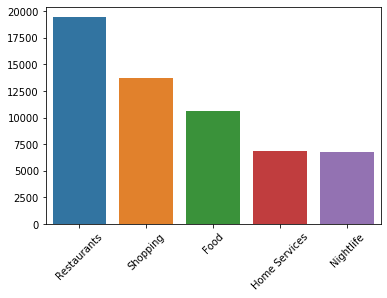

In [4]:
ds_business = pd.read_csv('yelp_business.csv')
business_categories=' '.join(ds_business['categories'])
indi = pd.DataFrame(business_categories.split(';'), columns=['categories'])
x = indi.categories.value_counts()
ds_categories=pd.DataFrame(x.sort_values(ascending=False))
sns.barplot(ds_categories.index, ds_categories.values.ravel(), order=ds_categories.categories.iloc[:5].index)
g = plt.xticks(rotation=45)

From the business dataset we can see, that the most reviewed categories on yelp are restaurants and shopping. We use these 2 groups to create binary dataset on which we we use multiple instance learning approach to categorize unseen reviews.

In [5]:
ds_restaurants = ds_business[(ds_business['categories'].str.contains('Restaurants')) & ~(ds_business['categories'].str.contains('Shopping'))]
ds_shopping = ds_business[(ds_business['categories'].str.contains('Shopping')) & ~(ds_business['categories'].str.contains('Restaurants')) & ~(ds_business['categories'].str.contains('Food')) & ~(ds_business['categories'].str.contains('Bars'))]

Now we pair business ids from business dataset and locate categorical reviews from reviews dataset

In [6]:
shopping_id = ds_shopping.business_id.values
shopping_reviews = ds_review.loc[ds_review['business_id'].isin(shopping_id)] # positive
shopping_reviews['label'] = 1

restaurant_id =ds_restaurants.business_id.values
restaurant_reviews = ds_review.loc[ds_review['business_id'].isin(restaurant_id)] # negative
restaurant_reviews['label'] = -1

In [7]:
del ds_restaurants
del ds_shopping

In [8]:
shopping_reviews['lang'] = shopping_reviews['text'].head(250).apply(lambda x: detect(x))
restaurant_reviews['lang'] = restaurant_reviews['text'].head(250).apply(lambda x: detect(x))

In [9]:
shopping_reviews = shopping_reviews[shopping_reviews['lang'] =='en']
restaurant_reviews = restaurant_reviews[restaurant_reviews['lang'] =='en']

Due to cardinality imbalance of reviews between 2 groups we use 2000 reviews from both categories 

In [10]:
pos_ds = shopping_reviews.head(200)
neg_ds = restaurant_reviews.head(200)
ds = pos_ds.append(neg_ds)
np.random.seed(42)
ds = ds.reindex(np.random.permutation(ds.index)) #shuffle
del pos_ds
del neg_ds
del ds_review
del ds_business
del shopping_reviews
del restaurant_reviews

## Preprocessing
We use pretrained google implementation of word2vec, which transforms words into vectors based on semantic meaning to other words.  
Example:  
word2vect('king') - word2vect('man') + word2vect('woman') = word2vect('queen')

In [11]:
%%time
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

CPU times: user 1min 18s, sys: 6.09 s, total: 1min 24s
Wall time: 1min 24s


In [12]:
text = ds.text.values
labels = ds.label.values
del ds

We now create multiple instance learning dataset, in which structure is following:  
mil_X = list(bag1, bag_2, ..., bag_n)  
Y = (1, 2, ..., n)  
Each bag denotes 1 review  
bag_i = list(instance_1, instance_2, ..., instance_m)  
Each instance denotes sentence in review as a mean of word2vect vectors, which appeared in sentence  

In [13]:
mil_X=[]
Y=[]
sup_X=[]
stop_words = set(stopwords.words("english")) # vocabulary which we use to limit individual in dataset
for review, label in zip(text, labels):
        bag = []
        sentence_list = review.split('.')
        for sentence in sentence_list:
            cl_sent = re.sub(r'([^\s\w]|_)+', '', sentence)
            clean_sentence = ''.join([i for i in cl_sent if not i.isdigit()]) # remove all numbers
            clean_sentence = clean_sentence.replace('\n', '')
            tokenized = clean_sentence.split(' ')
            sentence_vect = np.zeros(300)
            counter = 0
            for word in tokenized:
                l_word = word.lower()
                if l_word in stop_words: # if stop word we don't try to vectorize
                    break
                elif l_word:
                    try:
                        word_vect = model[l_word] # vector representation of wird 
                        sentence_vect = np.add(sentence_vect, word_vect)
                    except:
                        pass
            if np.isnan(np.sum(x)):
                sentence_vect = np.zeros(300)
                print(sentence)
            bag.append(sentence_vect)
        mil_X.append(bag)
        sup_X.append(sum(bag)/len(bag))
        Y.append(label)

In [14]:
del model
del stop_words
del text
del labels

Following code runs cross validation on multiple instance learning classifier for hyperparameter selection for almost 10 minutes and the resulting acc = 0.6375 

In [15]:
'''
%%time
train_X, test_X, train_Y, test_Y = train_test_split(mil_X, Y) # multiple instance learning dataset
best_params={'kernel':None, 'c': None}
best_acc = 0
k_valid =5
for kernel in ['linear', 'quadratic']:
    for c in [100, 1000, 10000]:
        acc_lst = []
        for cur_iteration in range(k_valid):
            x_train, x_val, y_train, y_val = batch_set(train_X,train_Y, cur_iteration, k_valid)
            classifier = misvm.MISVM(kernel=kernel, C=c, max_iters=30, verbose=False)
            classifier.fit(x_train, y_train)
            labels = classifier.predict(x_val)
            pred_y = np.sign(labels)
            accuracy = accuracy_score(y_val, pred_y)
            #print(confusion_matrix(y_val, pred_y))
            #print(accuracy)
            acc_lst.append(accuracy)
        mean = sum(acc_lst)/len(acc_lst)
        if mean > best_acc:
            best_acc = accuracy
            best_params['kernel'] = kernel
            best_params['c'] = c
        print('Results of {} kernel and C set to {}'.format(kernel, c))
        print('Mean = {}, std={}'.format(mean, np.std(np.array(acc_lst))))    
print('Selected parameters: {}'.format(best_params))
classifier = misvm.MISVM(kernel=best_params['kernel'], C=best_params['c'], max_iters=30, verbose=False)
classifier.fit(train_X, train_Y)
labels = classifier.predict(test_X)
pred_y = np.sign(labels)
accuracy = accuracy_score(test_Y, pred_y)
print(accuracy)
'''

"\n%%time\ntrain_X, test_X, train_Y, test_Y = train_test_split(mil_X, Y) # multiple instance learning dataset\nbest_params={'kernel':None, 'c': None}\nbest_acc = 0\nk_valid =5\nfor kernel in ['linear', 'quadratic']:\n    for c in [100, 1000, 10000]:\n        acc_lst = []\n        for cur_iteration in range(k_valid):\n            x_train, x_val, y_train, y_val = batch_set(train_X,train_Y, cur_iteration, k_valid)\n            classifier = misvm.MISVM(kernel=kernel, C=c, max_iters=30, verbose=False)\n            classifier.fit(x_train, y_train)\n            labels = classifier.predict(x_val)\n            pred_y = np.sign(labels)\n            accuracy = accuracy_score(y_val, pred_y)\n            #print(confusion_matrix(y_val, pred_y))\n            #print(accuracy)\n            acc_lst.append(accuracy)\n        mean = sum(acc_lst)/len(acc_lst)\n        if mean > best_acc:\n            best_acc = accuracy\n            best_params['kernel'] = kernel\n            best_params['c'] = c\n        

In [16]:
train_X, test_X, train_Y, test_Y = train_test_split(sup_X, Y) # supervised learning dataset

In [17]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}, 
                    {'kernel': ['poly'], 'C': [1, 10, 100, 1000]}]
cvscores = []

clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='accuracy'
    )
# create model
clf.fit(np.array(train_X), np.array(train_Y))
# evaluate the model
clf.predict(np.array(test_X))
print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Best parameters set found on development set:

{'C': 100, 'kernel': 'linear'}


In [18]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print('Prediction Time')
y_true, y_pred = test_Y, clf.predict(test_X)
print(confusion_matrix(y_true, y_pred))
print(accuracy_score(y_true, y_pred))

0.509 (+/-0.015) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.509 (+/-0.015) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.509 (+/-0.015) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.509 (+/-0.015) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.603 (+/-0.064) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.509 (+/-0.015) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.688 (+/-0.071) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.603 (+/-0.064) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.691 (+/-0.057) for {'C': 1, 'kernel': 'linear'}
0.691 (+/-0.082) for {'C': 10, 'kernel': 'linear'}
0.713 (+/-0.113) for {'C': 100, 'kernel': 'linear'}
0.694 (+/-0.102) for {'C': 1000, 'kernel': 'linear'}
0.594 (+/-0.044) for {'C': 1, 'kernel': 'poly'}
0.634 (+/-0.037) for {'C': 10, 'kernel': 'poly'}
0.647 (+/-0.106) for {'C': 100, 'kernel': 'poly'}
0.662 (+/-0.042) for {'C': 1000, 'kernel': 'poly'}

Prediction Time
[[31 12]
 [10 27]]
0.725


## Neural network text categorization approach
In this section we implement neural network in Keras library.

In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Imports

In [20]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect
from sklearn.model_selection import train_test_split

In [21]:
ds_review = pd.read_csv('yelp_review.csv')
ds_business = pd.read_csv('yelp_business.csv')

In [22]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [23]:
ds_restaurants = ds_business[(ds_business['categories'].str.contains('Restaurants')) & ~(ds_business['categories'].str.contains('Shopping'))]
ds_shopping = ds_business[(ds_business['categories'].str.contains('Shopping')) & ~(ds_business['categories'].str.contains('Restaurants')) & ~(ds_business['categories'].str.contains('Food')) & ~(ds_business['categories'].str.contains('Bars'))]
shopping_id = ds_shopping.business_id.values
shopping_reviews = ds_review.loc[ds_review['business_id'].isin(shopping_id)] # positive
shopping_reviews['label'] = 1

restaurant_id =ds_restaurants.business_id.values
restaurant_reviews = ds_review.loc[ds_review['business_id'].isin(restaurant_id)] # negative
restaurant_reviews['label'] = 0
np.random.seed(42)

shopping_reviews['lang'] = shopping_reviews['text'].head(4000).apply(lambda x: detect(x))
restaurant_reviews['lang'] = restaurant_reviews['text'].head(4000).apply(lambda x: detect(x))

shopping_reviews = shopping_reviews[shopping_reviews['lang'] =='en']
restaurant_reviews = restaurant_reviews[restaurant_reviews['lang'] =='en']

pos_ds = shopping_reviews.head(2000)
neg_ds = restaurant_reviews.head(2000)
ds1 = pos_ds.append(neg_ds)
ds1['text'] = ds1['text'].str.lower()
X = ds1['text'] # the features we want to analyze
ylabels = ds1['label'] # the labels, or answers, we want to test against
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=1/3, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = 5000
xtrain = tokenizer.texts_to_sequences(X_train)
xtest = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1


maxlen=100
# Pad sequences with zeros
X_train = pad_sequences(xtrain, padding='post', maxlen=maxlen)
X_test = pad_sequences(xtest, padding='post', maxlen=maxlen)

vocab_size=len(tokenizer.word_index)+1


embedding_dim = 100

# We will use glove for pretrained embeding matrix
embedding_matrix = create_embedding_matrix('glove.6B.100d.txt',tokenizer.word_index, embedding_dim)

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=20))
model.add(Dropout(0.5))
model.add(Dense(8))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", 
     metrics=['accuracy'])
model.summary()


    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1543200   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 168       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,579,257
Trainable params: 1,579,257
Non-trainable params: 0
____________________________________________

Training Accuracy: 0.9974
Testing Accuracy:  0.9640


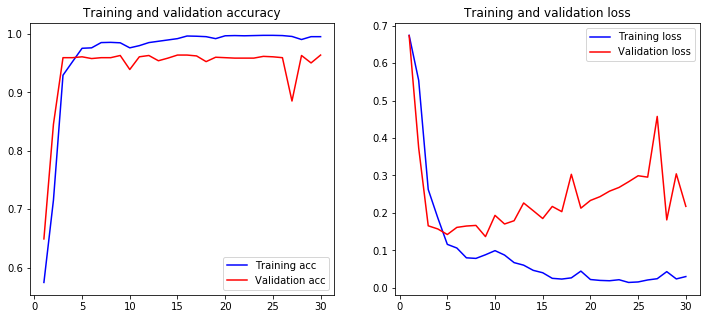

In [24]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [25]:
pos_ds = shopping_reviews.tail(1000)
neg_ds = restaurant_reviews.tail(1000)
ds2 = pos_ds.append(neg_ds)
ds2['text'] = ds2['text'].str.lower()

Lets check if training dataset and testing dataset have any common reviews

In [26]:
idx = ds1.index.intersection(ds2.index)
print (len(idx))

0


In [27]:
X_test = ds2['text']
y_test = ds2['label']

In [28]:
xtest = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(xtest, padding='post', maxlen=maxlen)

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.9645
